In [60]:
import torch
import datasets
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import pandas as pd
import math
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import numpy as np
import transformers
from joblib import dump, load
seed = 42

In [61]:
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)
random.seed(seed)


In [62]:
class TransformerModel(torch.nn.Module):
    def __init__(self, num_features, num_classes, dim_model, num_heads, num_layers, dropout_rate):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(num_features, dim_model)  # Project input features to dim_model
        self.transformer_layer = torch.nn.TransformerEncoderLayer(
            d_model=dim_model,   # Use dim_model here
            nhead=num_heads,
            dropout=dropout_rate
        )
        self.encoder = torch.nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(dim_model, 1)  # Match dim_model with output_layer input size

    def forward(self, src):
        src = self.embedding(src)  # Project the input features to the model dimension[batch_size, 1, feature_dim]
        #print('src1',src.shape)
        src = src.unsqueeze(1)
        #src = src.permute(1, 0, 2)  # Rearrange to [seq_len, batch_size, feature_dim]
        #print('src2',src.shape)
        x = self.encoder(src)
        x = torch.mean(x, dim=1)  # Mean pooling over the sequence length
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x


In [63]:
def get_data(split: str,data_dir:str, silent: bool = False, cache_dir: str = None):
    print(f'Loading ECG dataset ({split} split) from Huggingface...')
    dataset = datasets.load_dataset('honggen-organization/ECG-disease-clf', split=split, data_dir=data_dir, cache_dir=cache_dir)
    print('done')
    return dataset
def binary_preprocess(disease_data, normal_data,augment = True,downsample = False, test = False, scaler = None,):
    # Convert to pandas
    disease_df = disease_data.data.to_pandas()#[feature_list]
    normal_df = normal_data.data.to_pandas()#[feature_list]

    #if test:
        #disease_df = disease_df[disease_df['Group'] == 6]
        #normal_df = normal_df[normal_df['Group'] == 6]
        


    # Filter normal_df to match disease groups
    normal_df = normal_df[normal_df['Group'].isin(set(disease_df['Group']))]
    #disease_df = disease_df.drop('Group', axis=1)
    #normal_df = normal_df.drop('Group', axis=1)
    if augment:
        upsample_factor = math.floor(len(normal_df) / len(disease_df))
        disease_sampled = disease_df.sample(len(normal_df)-upsample_factor*len(disease_df), replace=True, random_state=40).reset_index(drop=True)
        disease_df = pd.concat([disease_df] * int(upsample_factor)).reset_index(drop=True)
        disease_df = pd.concat([disease_df,disease_sampled]).reset_index(drop=True)

    if downsample:
        normal_df= normal_df.sample(n=len(disease_df), random_state=42).reset_index(drop=True)

    # Concatenate and shuffle the datasets
    combined_df = pd.concat([disease_df.assign(label=1), normal_df.assign(label=0)]).sample(frac=1).reset_index(drop=True)
    
    # Convert to PyTorch tensors
    X_train = combined_df.iloc[:, :-1].values
    if scaler is None:
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
    else:
        print('normalize using the train scaler')
        X_train = scaler.transform(X_train)
    dump(scaler, './transformer_KD_scaler.joblib') 

    features = torch.tensor(X_train, dtype=torch.float)
    labels = torch.tensor(combined_df['label'].values, dtype=torch.long)

    return TensorDataset(features, labels),scaler


Loading ECG dataset (train split) from Huggingface...
done
Loading ECG dataset (test split) from Huggingface...
done
Loading ECG dataset (train split) from Huggingface...
done
Loading ECG dataset (test split) from Huggingface...
done
normalize using the train scaler


/home/honggen/.local/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


true negative (normal):  0.6803394625176803
true positive (disease):  0.9066666666666666


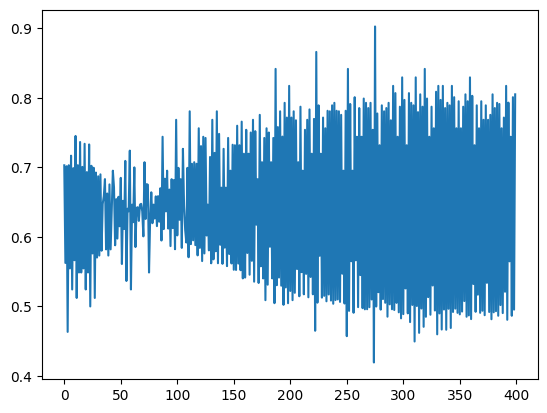

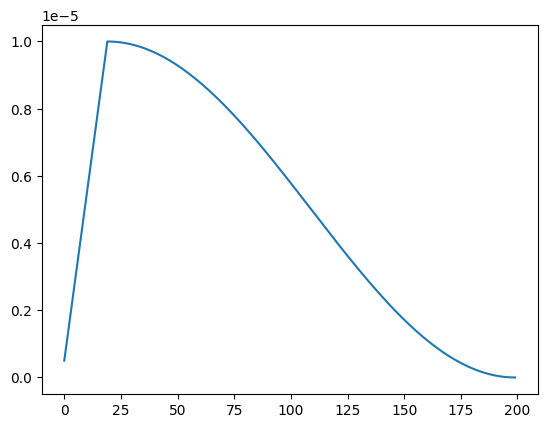

In [67]:
data_method = 'downsample'
data_name = 'kd'
augment = False
downsample = True
normal_data_train = get_data(split= 'train', data_dir = 'normal', cache_dir = './cache/huggingface/datasets')
normal_data_test = get_data(split= 'test', data_dir = 'normal', cache_dir = './cache/huggingface/datasets')

for i in range(1,2):
    batch_size = 512
    epochs = 100
    kd_data_train = get_data(split= 'train', data_dir = f"{data_name}/data{i}", cache_dir = './cache/huggingface/datasets')
    kd_data_test = get_data(split= 'test', data_dir = f"{data_name}/data{i}", cache_dir = './cache/huggingface/datasets')
    data_train,scaler = binary_preprocess(kd_data_train, normal_data_train,augment = augment,downsample = downsample,)
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=False)

    data_test,_ = binary_preprocess(kd_data_test, normal_data_test,augment = False,downsample = False,test = True,scaler = scaler)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False, drop_last=False)


    model = TransformerModel(num_features=170, num_classes=2, dim_model=64, num_heads=2, num_layers=4, dropout_rate=0.2)
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    scheduler = transformers.get_cosine_schedule_with_warmup(
            optimizer = optimizer, 
            num_warmup_steps =len(train_loader)*10,
            num_training_steps = len(train_loader)*epochs,
        )
    epochs = epochs
    loss_list = []
    lr_list = []
    model.train()
    for epoch in range(epochs):
        for features, labels in train_loader:
            #print(labels.shape)
            a = labels.shape[0]
            #features=features.view(a,1,170)
            #print(features.shape)
            optimizer.zero_grad()
            outputs = model(features)
            #print(outputs)
            #print(labels.shape)
            loss = criterion(outputs.squeeze(), labels.float())
            predicted_ = (outputs.squeeze() > 0.5).float()
            accuracy = accuracy_score(labels.numpy(), predicted_.detach().numpy())
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            learn_rate = scheduler.get_last_lr()
            lr_list.append(learn_rate)
            loss_list.append(loss.item())
            loss_list.append(accuracy)
    plt.figure()
    plt.plot(loss_list)
    plt.figure()
    plt.plot(lr_list)
    ##########################################
    total_loss  = 0
    all_predict = []
    all_label = []
    all_prob = []
    model.eval()
    with torch.no_grad():  # No need to track gradients during evaluation
        for data in test_loader:
            inputs, labels = data[0], data[1]
            a = labels.shape[0]
            #inputs=inputs.view(a,1,169)
            outputs = model(inputs)
            prob = outputs.squeeze()
            predicted = (prob > 0.5).float()
    
            #_, predicted = torch.max(outputs, dim=1)
            all_predict.extend(list(predicted))
            all_label.extend(labels.cpu().numpy())
    tn, fp, fn, tp = confusion_matrix(all_label,all_predict).ravel()
    print('true negative (normal): ', tn/(tn+fp))
    print('true positive (disease): ',tp/(tp+fn))

    
#df_tnr = pd.DataFrame(tnr_all, columns = ['transformer'])
#df_tnr.to_csv(f"./{data}_roc/{data_method}/transformer_tnr.csv", index=False)
#df_tpr = pd.DataFrame(tpr_all, columns = ['transformer'])
#df_tpr.to_csv(f"./{data}_roc/{data_method}/transformer_tpr.csv", index=False) 


In [68]:
model_save_path = "./transformer_model.pth"

# Save model state and optimizer state (optional)
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),  # optional if scheduler is used
}, model_save_path)


In [ ]:
model = TransformerModel(num_features=170, num_classes=2, dim_model=64, num_heads=2, num_layers=4, dropout_rate=0.2)
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint['model_state_dict'])
